# Neural Style Transfer in Python

This notebook contains the code for part three of the CMI project for 2023/2024. All the code presented below has been retrieved from the following site of [tensor flow](https://www.tensorflow.org/tutorials/generative/style_transfer?hl=fr). The aim is not to build a model capable of applying a style transfer to an image but to understand how it works.

### Prepare the environment

To speed up the compilation time for this code, we recommend using a CPU.

In [ ]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

2024-05-20 11:13:39.290582: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 11:13:39.290642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 11:13:39.292285: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Import librairies

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
from PIL import Image
import time
import functools
import tensorflow_hub as hub

In [3]:
def tensor_to_image(tensor):
    tensor = tensor*255 # pixels standartisatoin
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3: # Check if it is an image or a list of image
        assert tensor.shape[0] == 1 # if it's a list,
        tensor = tensor[0] # Get the first image
    return PIL.Image.fromarray(tensor) # Return the image as a PIL.Image format


### Image visualisation

In [4]:
def load_img(path_to_img):
    max_dim = 512

    # Load the image
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3) # channels = 3 for RGB
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)

    # Resize the image
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)



#### Data use

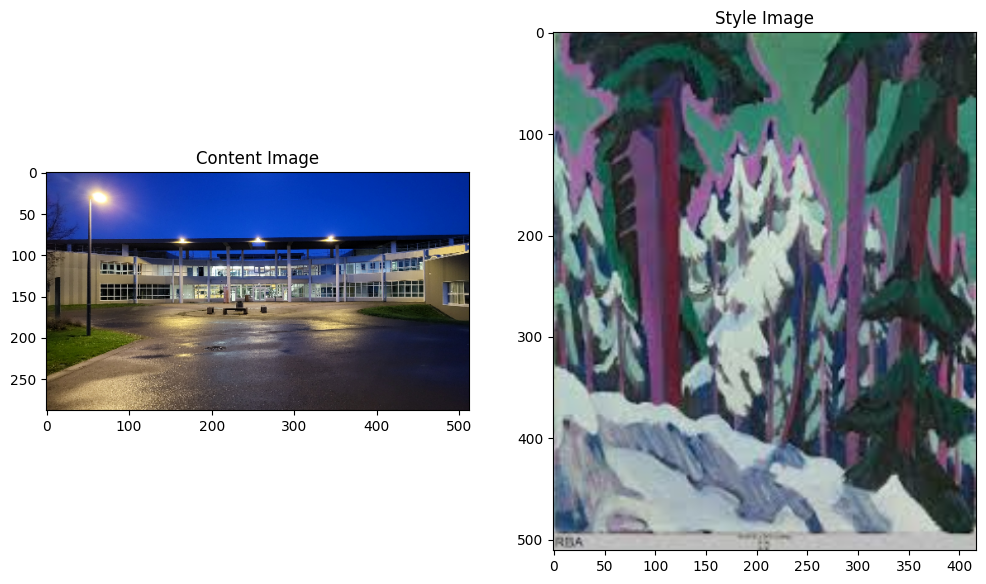

In [5]:
content_path = "./style_transfer_pictures/content_image.jpg"
style_path = "./style_transfer_pictures/style_image.jpg"

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')


### Use of the library hub to do the style transfert

[Hub](https://www.tensorflow.org/hub?hl=fr) is a library that is use as a model loader. Thanks to it, users can access to a lot of differents ML and DL models to handle tasks.

For neural styke transfer, we will use the model [arbitrary-image-stylization-v1-256](https://link.springer.com/chapter/10.1007/978-1-4842-7341-8_12).

In [6]:
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
img = tensor_to_image(stylized_image)

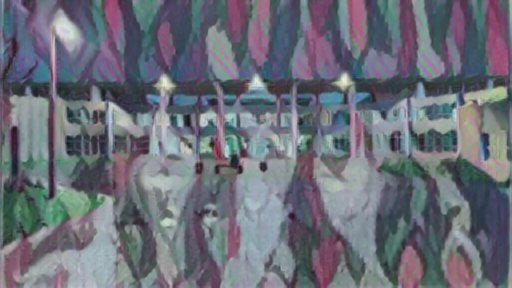

In [7]:
img

### Neural Transfer style by coding our own model (not really)

In this section, the different steps used to create a neural network capable of transferring the style of one image to another image will be presented.

#### Download of VGG19 model

The first step is to download a pre-trained model for image classification. For the most of the tutorial that you can find on internet, VGG16 and VGG19 are used. In the tensorflow example, it is VGG19.

VGG19 is a Convolutionnal Neural Network trained by the Oxford university team. It is predicting the content of an image (between 1000 different labels). VGG19 is a =n extension of VGG16 with 3 more layers.

Above is an example of how to do predictions with VGG19.

In [8]:
# Preprocessing on the image to get the right format
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))

# Make the prediction
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape # tensor of 1000 probabilities (1 for each class)

TensorShape([1, 1000])

Prediction of the 5 more probable classes.

In [9]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('palace', 0.76183647),
 ('fountain', 0.038947683),
 ('prison', 0.022770105),
 ('lakeside', 0.022283677),
 ('cinema', 0.020105606)]

These results show that our forest look like a geyser :(

Here is the architecture of VGG19

In [10]:
for layer in vgg.layers:
  print(layer.name)

input_layer
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
flatten
fc1
fc2
predictions


#### Loads of the model without the classification layers

Now, we want to load VGG19 without the classification layers because we will not use it for the same task. So we have to remove fc1, fc2, and the predictions layer. The goal of fc1 and fc2 is to capture the caracteristics of the shapes learned by all the convolutionnal layers. And the goal of the last layer is to do the prediction.

In [11]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)



input_layer_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In order to do style transfer, there is to task that our neural network has to do.
* The content task
* The style task

The aim is to capture the content of the image_content and the style of our image_style.

For this, it is important to affect some of our layers to do those tasks. The content layer need to be a deep one. In this case a deep layer has a lot of information about the content of the image, the shapes, the structure, ...
For the style content, several layers are used. Some of them are deep and other aren't. It will allows our model to capture local detail style like a more general style.

#### Affectation of the style task to some layers of the CNN


In [12]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

 Creation of a VGG19 model that is outputing intermediate results for style_extraction

In [13]:
def vgg_layers(layer_names):
    # Get the VGG model without classification layers
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    # Diseable learning to make the model extracting information without modifying neurones
    vgg.trainable = False
    # Get the outputs of all the intermediate layers
    outputs = [vgg.get_layer(name).output for name in layer_names]
    # Creation of a model using the model inputs (images) and the intermediate layers output (content and style)
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [14]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()


block1_conv1
  shape:  (1, 511, 417, 64)
  min:  0.0
  max:  731.4576
  mean:  20.637175

block2_conv1
  shape:  (1, 255, 208, 128)
  min:  0.0
  max:  2660.105
  mean:  121.77049

block3_conv1
  shape:  (1, 127, 104, 256)
  min:  0.0
  max:  7629.089
  mean:  127.323875

block4_conv1
  shape:  (1, 63, 52, 512)
  min:  0.0
  max:  15197.193
  mean:  481.5509

block5_conv1
  shape:  (1, 31, 26, 512)
  min:  0.0
  max:  2127.0193
  mean:  37.539955



Upstairs are the information of each intermediate layers of our style extractor. The shape is shape of the output of the layer and min, max and mean are some data about the outputs of the layer.

#### Calcul the style of an image.

To calcul the style of an image, it is important to calculate the gram matrix. It is use to represent the style of an image. To calculate this matrix, we need to use all the style characteristics returned by our intermediate layers. Than we do the scalar product between all the vectors of the retrieved characteristics. It is a way to calcule the correlation between the our style characteristics.

In [15]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

#### Extract style and content

It is now possible to create a model that can extract the content of an image and the style of an other one.

In [16]:
class StyleContentModel(tf.keras.models.Model):

    # Initialisation of the parameters of our model
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        # For each output of the style extractor, we apply the gram matrix
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        # Retrieving the content of the intermediate outputs for each style or content layers
        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}


In [17]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.09817309
    max:  25109.57
    mean:  1007.40985

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  193423.64
    mean:  20420.414

   block3_conv1
    shape:  (1, 256, 256)
    min:  4.8679295
    max:  637170.6
    mean:  21443.62

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  5867550.5
    mean:  338758.53

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  173207.4
    mean:  2401.797

Contents:
   block5_conv2
    shape:  (1, 18, 32, 512)
    min:  0.0
    max:  1349.3467
    mean:  17.085577


#### Gradient descent

Now that the style content extractor exist, the optimization of the algorithm is possible. For that, we have to find some metrics to minimize appliyng a gradient descent.

Here are the targets that we want to optimize:

In [18]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Here is our content image accessible thanks to a tensor

In [19]:
image = tf.Variable(content_image)

In [20]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

For optimization, we will use Adam optimizer:

In [21]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [22]:
style_weight=1e-2
content_weight=1e4

Here is the loss that we want to optimize. It is a combinaison of our style loss and our content loss.

The style loss is the mean squared difference between the style features of the generated image and the style features of our style image:

$\text{style_loss} = \frac{\text{style_weight}}{\text{num_style_layers}} \times \sum_{\text{layer} \in \text{layers}} \text{mean}\left( (\text{style_outputs[layer]} - \text{style_targets[layer]})^2 \right)$

The content loss is also using the mean square error:

$\text{content_loss} = \frac{\text{content_weight}}{\text{num_content_layers}} \times \sum_{\text{layer} \in \text{layers}} \text{mean}\left( (\text{content_outputs[layer]} - \text{content_targets[layer]})^2 \right)$

Note that in this notebook, there is just one layer that is use for the content optimization.

Our global loss is $\text{loss} = \text{style_loss} + \text{content_loss}$

In [23]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss, style_loss, content_loss

#### First train without TV loss

In [24]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))


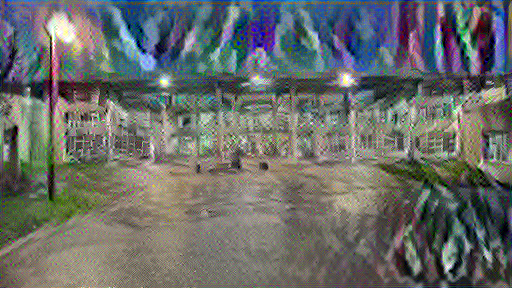

Train step: 1000
Total time: 61.8


In [25]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))


#### TV Loss

The TV loss is measuring the loss of regularity in an image. Basically, it is just comparing neighbours pixels. When two neightbours pixels are similar, the loss is not increasing but when two neightbours pixels are really different, the loss increase a lot. The formula of this loss is:

$\text{TV loss} = \sum_{i, j} \left| I_{i+1, j} - I_{i, j} \right| + \left| I_{i, j+1} - I_{i, j} \right|$

In [26]:
def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

    return x_var, y_var


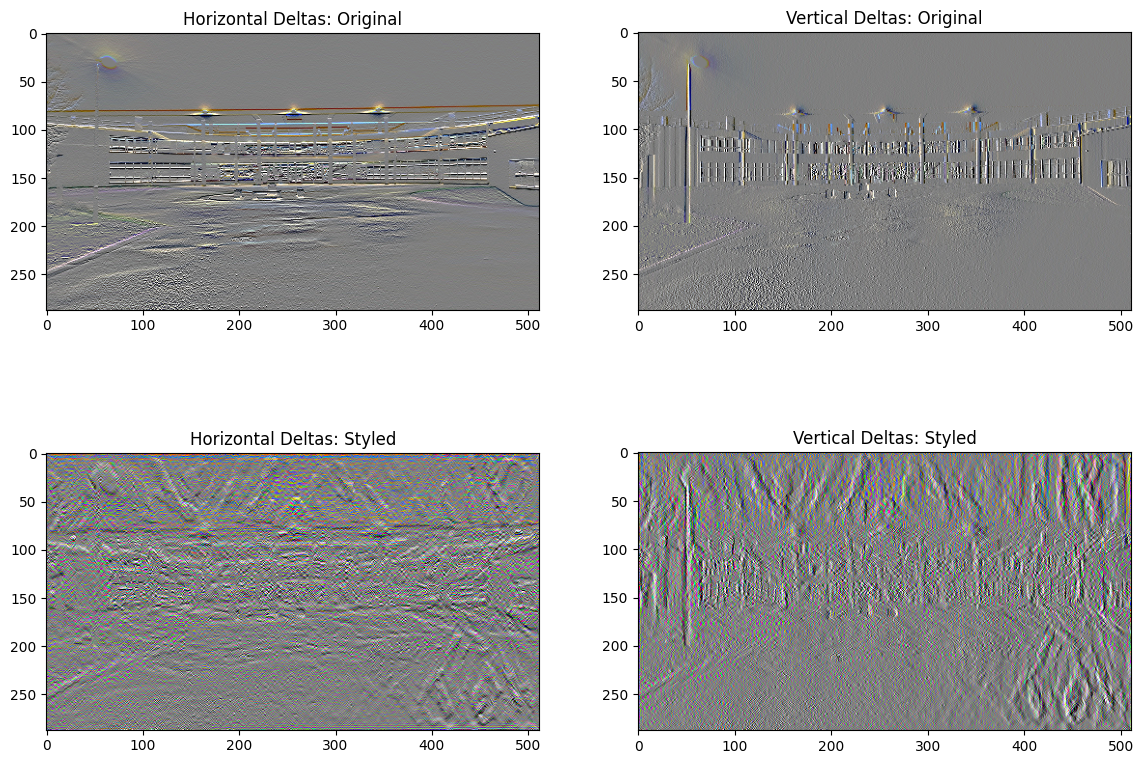

In [27]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")


The phenomenom is appearing upstairs.

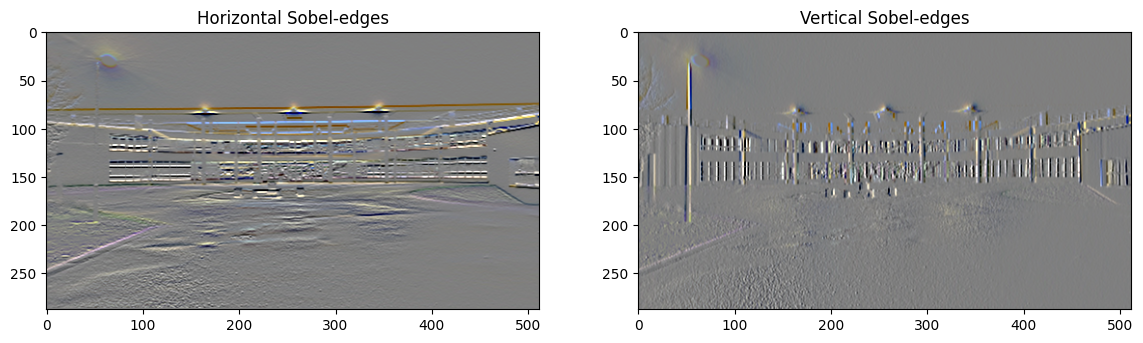

In [28]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")


In [29]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))


In [30]:
total_variation_loss(image).numpy()


72747.22

In [31]:
tf.image.total_variation(image).numpy()


array([72747.22], dtype=float32)

#### Restart optimisation with the the TV loss

In [32]:
total_variation_weight=30


In [33]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss, style_loss, content_loss = style_content_loss(outputs)
        tv_loss = total_variation_weight*total_variation_loss(image)
        loss += tv_loss

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    return loss, tv_loss, style_loss, content_loss


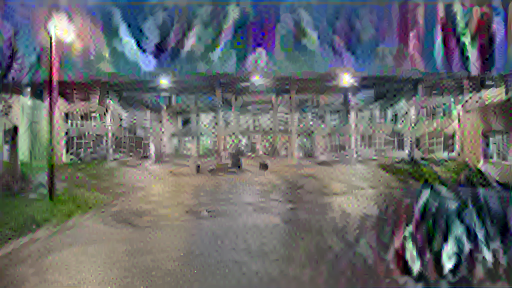

Train step: 1000
Total time: 63.2


In [35]:
import time
start = time.time()

epochs = 100
steps_per_epoch = 10
losses = []
content_losses = []
style_losses = []
tv_losses = []

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        loss, tv_loss, style_loss, content_loss = train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
    losses.append(loss.numpy())
    content_losses.append(content_loss.numpy())
    style_losses.append(style_loss.numpy())
    tv_losses.append(tv_loss.numpy())

end = time.time()
print("Total time: {:.1f}".format(end-start))


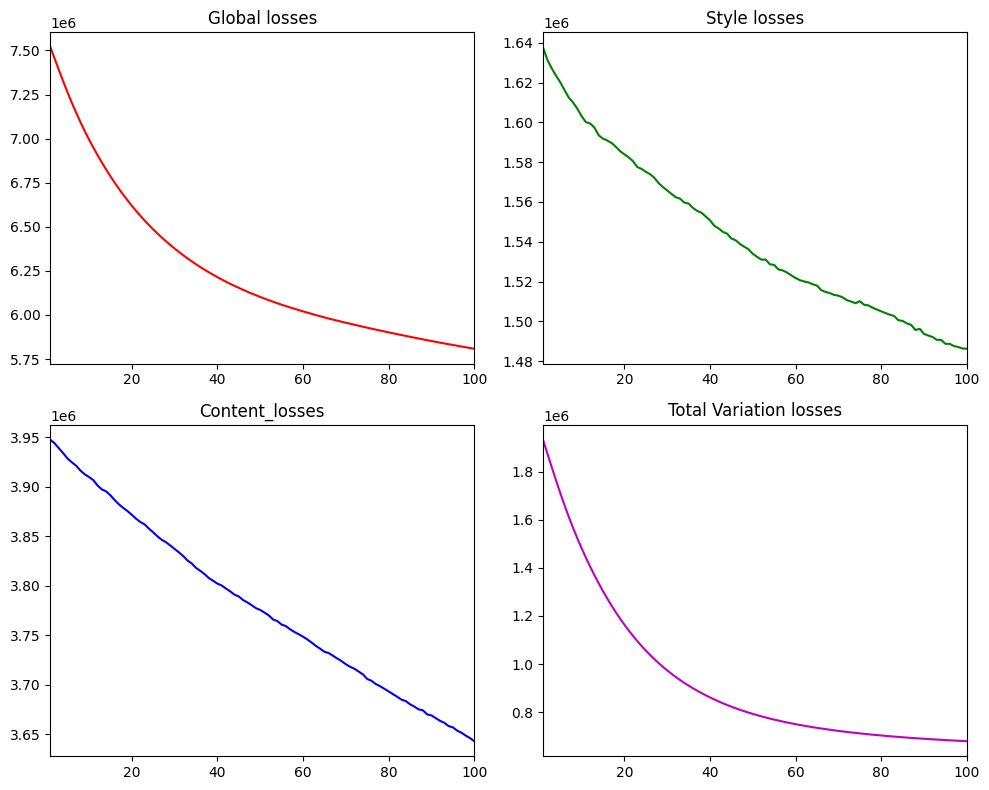

In [36]:
x = np.linspace(1, 100, 100)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot the first curve
axs[0, 0].plot(x, losses, 'r-')  # Red line
axs[0, 0].set_title('Global losses')
axs[0, 0].set_xlim(1, 100)

# Plot the second curve
axs[0, 1].plot(x, style_losses, 'g-')  # Green line
axs[0, 1].set_title('Style losses')
axs[0, 1].set_xlim(1, 100)

# Plot the third curve
axs[1, 0].plot(x, content_losses, 'b-')  # Blue line
axs[1, 0].set_title('Content_losses')
axs[1, 0].set_xlim(1, 100)


# Plot the fourth curve
axs[1, 1].plot(x, tv_losses, 'm-')  # Magenta line
axs[1, 1].set_title('Total Variation losses')
axs[1, 1].set_xlim(1, 100)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [37]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)
